# Evaluation of the 3 datasets with ML

In [1]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [2]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize (not number) / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

def prep_text(texts, tokenizer, **hparams):
    """
    Turns text into into padded sequences.
    """
    # kwargs.get("local", False)
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = hparams["max_sequence_length"], padding='post')

def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)
    
def get_metrics(y_test, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/julienseguy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parameters

In [3]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 40
}

## Loading Datasets

### Loading `politifact_scrap.csv`

In [4]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [5]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: ['washington', 'public', 'school', 'force', 'unvaccinated', 'teen', 'wear', 'ankle', 'monitor', 'condition', 'playing', 'team', 'sport']
--------------------------------------------------------------------------------


In [6]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


In [7]:
tokenizer_P = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_P.fit_on_texts(X_P_train)

X_P_train_pad = prep_text(X_P_train, tokenizer_P, **hparams)
X_P_test_pad = prep_text(X_P_test, tokenizer_P, **hparams)

print('-'*80)
print(f"X_P_train_pad shape: {X_P_train_pad.shape}")
print(f"X_P_pad shape: {X_P_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_P.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_pad shape: (15860, 40)
X_P_pad shape: (3966, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `FakeNewsNET`

In [8]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [9]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: ['djou', 'win', 'special', 'election', 'congress']
--------------------------------------------------------------------------------


In [10]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


In [11]:
tokenizer_F = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_F.fit_on_texts(X_P_train)

X_FNN_train_pad = prep_text(X_FNN_train, tokenizer_F, **hparams)
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_F, **hparams)

print('-'*80)
print(f"X_FNN_train_pad shape: {X_FNN_train_pad.shape}")
print(f"X_FNN_pad shape: {X_FNN_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_F.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_pad shape: (15424, 40)
X_FNN_pad shape: (3857, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [12]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [13]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [14]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [15]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: ['u', 'budget', 'fight', 'loom', 'republican', 'flip', 'fiscal', 'script']
--------------------------------------------------------------------------------


In [16]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


In [17]:
tokenizer_B = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_B.fit_on_texts(X_P_train)

X_BIS_train_pad = prep_text(X_BIS_train, tokenizer_B, **hparams)
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_B, **hparams)

print('-'*80)
print(f"X_BIS_train_pad shape: {X_BIS_train_pad.shape}")
print(f"X_BIS_pad shape: {X_BIS_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_B.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_pad shape: (35751, 40)
X_BIS_pad shape: (8938, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Merging `All`

In [18]:
X_all = pd.concat([X_P, X_FNN, X_BIS]).reset_index(drop=True)
y_all = pd.concat([y_P, y_FNN, y_BIS]).reset_index(drop=True)

print('-'*80)
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_all shape: (83796,)
y_all shape: (83796,)
--------------------------------------------------------------------------------


In [19]:
X_ALL_train, X_ALL_test, y_ALL_train, y_ALL_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_ALL_train shape: {X_ALL_train.shape}")
print(f"y_ALL_train shape: {y_ALL_train.shape}")
print('-'*80)
print(f"X_ALL_test shape: {X_ALL_test.shape}")
print(f"y_ALL_test shape: {y_ALL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALL_train.sum()/len(y_ALL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALL_test.sum()/len(y_ALL_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train shape: (67036,)
y_ALL_train shape: (67036,)
--------------------------------------------------------------------------------
X_ALL_test shape: (16760,)
y_ALL_test shape: (16760,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 46.453
Fake (1) proportion in test (%): 46.718
--------------------------------------------------------------------------------


In [20]:
tokenizer_ALL = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_ALL.fit_on_texts(X_ALL_train)

X_ALL_train_pad = prep_text(X_ALL_train, tokenizer_ALL, **hparams)
X_ALL_test_pad = prep_text(X_ALL_test, tokenizer_ALL, **hparams)

print('-'*80)
print(f"X_ALL_train_pad shape: {X_ALL_train_pad.shape}")
print(f"X_ALL_pad shape: {X_ALL_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_ALL.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train_pad shape: (67036, 40)
X_ALL_pad shape: (16760, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 25526
--------------------------------------------------------------------------------


## Model

### Word2Vec

In [93]:
import gensim.downloader
# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


NameError: name 'Word2Vec' is not defined

In [97]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

glove_vectors.most_similar('twitter')

[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342358708381653),
 ('instagram', 0.9104824066162109),
 ('chat', 0.8964964747428894),
 ('hashtag', 0.8885937333106995),
 ('tweets', 0.8878158330917358),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

In [94]:
# from gensim.models import Word2Vec

# model = Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, norm_only=True)

# dog = model['dog']
# print(dog.shape)
# print(dog[:10])

AttributeError: type object 'Word2Vec' has no attribute 'load_word2vec_format'

In [ ]:
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=X_train, vector_size=10, min_count=10, window=10)

Word2Vec.

unique = set([_ for elt in X_train for _ in elt])

print('-'*80)
print(f"X_train vocabulary size: {len(unique)}")
print(f"word2vec vocabulary size: {len(word2vec.wv.key_to_index)}")    
print('-'*80)

In [ ]:
def embed_sentence(word2vec, sentence):
    embed_matrix = []
    for word in sentence:
        if word in word2vec.wv.key_to_index:
            embed_matrix.append(word2vec.wv[word])
    return np.array(embed_matrix)

def embedding(word2vec, sentences):
    return [embed_sentence(word2vec, sentence) for sentence in sentences]

In [ ]:
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)

X_train_embed[0].shape

In [ ]:
# and after padding ...

### Glove

In [85]:
import io
import urllib
import zipfile

zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_file = urllib.request.urlopen(zip_file_url)
archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

def get_embedding(archive, tokenizer, **hparams):
    """
    Pre-trained GloVe word vector embeddings
    """
    embeddings_index = {}
    glove_file = "glove.6B.100d.txt"

    with archive.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8") 
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

### Model

In [27]:
METRICS = [
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

def init_model(embedding_matrix, metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

2021-08-29 08:54:07.777748: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## `politifact_scrap.csv`

### Model

In [88]:
embedding_matrix_P = get_embedding(archive, tokenizer_P, **hparams)

print('-'*80)
print(f"embedding_matrix_P shape: {embedding_matrix_P.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_P shape: (12714, 100)
--------------------------------------------------------------------------------


In [87]:
init_model(embedding_matrix_P, **hparams).summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 1, 128)          

### Training

In [38]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

P_model = init_model(embedding_matrix_P, **hparams)

history = P_model.fit(X_P_train_pad, 
                  y_P_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
100/100 [==============================] - 3s 28ms/step - loss: 0.6445 - accuracy: 0.6177 - precision: 0.6348 - recall: 0.6968 - val_loss: 0.6178 - val_accuracy: 0.6390 - val_precision: 0.7026 - val_recall: 0.5878
Epoch 2/30
100/100 [==============================] - 2s 22ms/step - loss: 0.6059 - accuracy: 0.6657 - precision: 0.7035 - recall: 0.6626 - val_loss: 0.6275 - val_accuracy: 0.6422 - val_precision: 0.6912 - val_recall: 0.6230
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.5692 - accuracy: 0.6873 - precision: 0.7321 - recall: 0.6676 - val_loss: 0.6463 - val_accuracy: 0.6378 - val_precision: 0.6524 - val_recall: 0.7206
Epoch 4/30
100/100 [==============================] - 2s 21ms/step - loss: 0.5122 - accuracy: 0.7279 - precision: 0.7841 - recall: 0.6874 - val_loss: 0.7016 - val_accuracy: 0.6141 - val_precision: 0.6231 - val_recall: 0.7425
Epoch 5/30
100/100 [==============================] - 2s 20ms/step - loss: 0.4516 - accuracy: 0.7751

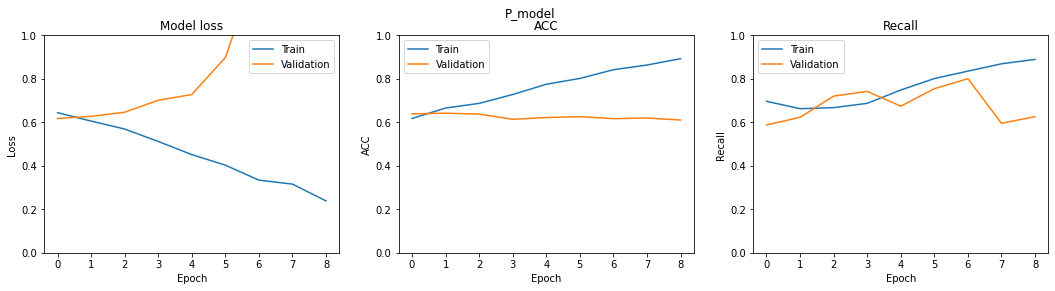

In [39]:
plot_loss(history, title='P_model')

--------------------------------------------------------------------------------
acc: 64.22%
recall: 59.72%
precision: 69.52%
f1: 64.25%
--------------------------------------------------------------------------------


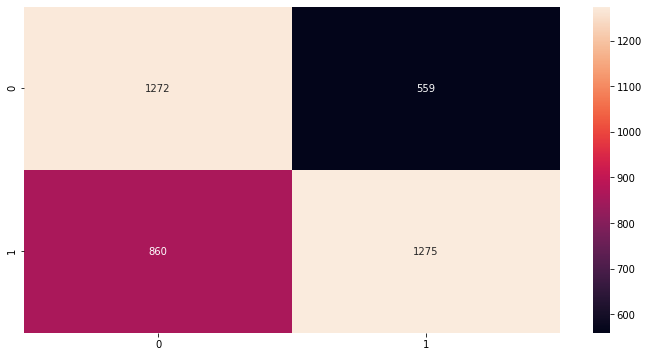

In [40]:
get_metrics(y_P_test, X_P_test_pad, P_model)

### Saving the model

In [42]:
# Colab
# model_name = 'P_model'

# Notebook
model_name = '../raw_data/P_model'

P_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/P_model/assets


### Uploading the model

In [43]:
reconstructed_P_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 64.22%
recall: 59.72%
precision: 69.52%
f1: 64.25%
--------------------------------------------------------------------------------


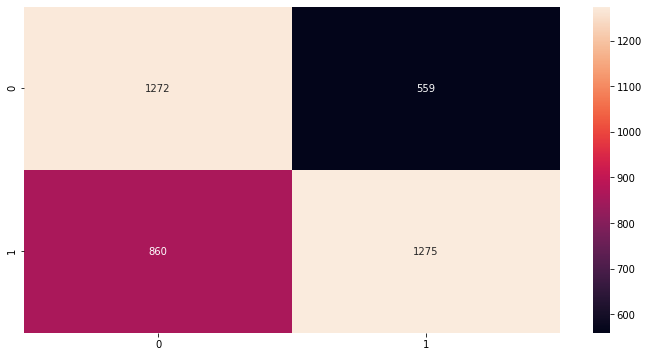

In [44]:
get_metrics(y_P_test, X_P_test_pad, reconstructed_P_model)

### `P_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 30.33%
recall: 94.42%
precision: 25.38%
f1: 40.01%
--------------------------------------------------------------------------------


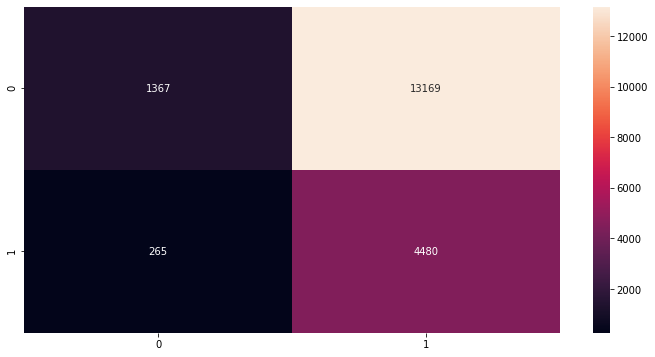

In [45]:
X_FNN_pad = prep_text(X_FNN, tokenizer_P, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_P_model)

### `P_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 54.28%
recall: 91.78%
precision: 53.81%
f1: 67.84%
--------------------------------------------------------------------------------


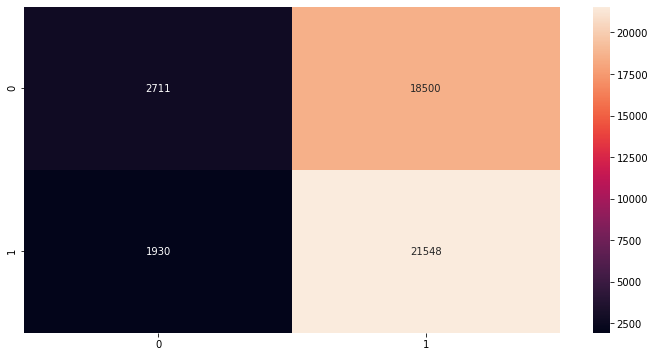

In [46]:
X_BIS_pad = prep_text(X_BIS, tokenizer_P, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_P_model)

## `FakeNewsNET`

### Model

In [90]:
embedding_matrix_F = get_embedding(archive, tokenizer_F, **hparams)

print('-'*80)
print(f"embedding_matrix_F shape: {embedding_matrix_F.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_F shape: (12714, 100)
--------------------------------------------------------------------------------


In [48]:
init_model(embedding_matrix_F, **hparams).summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 1, 128)           

### Training

In [51]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

F_model = init_model(embedding_matrix_F, **hparams)

history = F_model.fit(X_FNN_train_pad, 
                  y_FNN_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
97/97 [==============================] - 3s 29ms/step - loss: 0.5424 - accuracy: 0.7573 - precision: 0.5927 - recall: 0.0766 - val_loss: 0.4898 - val_accuracy: 0.7724 - val_precision: 0.7434 - val_recall: 0.1456
Epoch 2/30
97/97 [==============================] - 2s 23ms/step - loss: 0.4704 - accuracy: 0.7923 - precision: 0.6993 - recall: 0.2850 - val_loss: 0.4630 - val_accuracy: 0.7896 - val_precision: 0.6584 - val_recall: 0.3402
Epoch 3/30
97/97 [==============================] - 3s 26ms/step - loss: 0.4078 - accuracy: 0.8206 - precision: 0.7354 - recall: 0.4324 - val_loss: 0.4752 - val_accuracy: 0.7938 - val_precision: 0.6542 - val_recall: 0.3827
Epoch 4/30
97/97 [==============================] - 3s 29ms/step - loss: 0.3371 - accuracy: 0.8555 - precision: 0.7659 - recall: 0.6010 - val_loss: 0.5217 - val_accuracy: 0.7637 - val_precision: 0.5310 - val_recall: 0.5180
Epoch 5/30
97/97 [==============================] - 3s 26ms/step - loss: 0.2712 - accuracy: 0.8852 - precisi

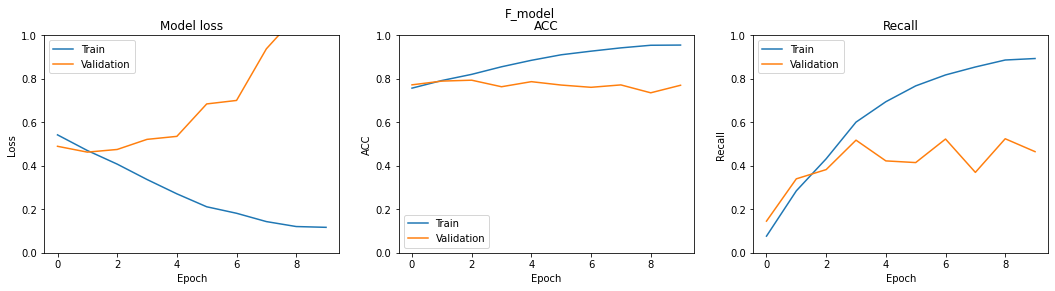

In [52]:
plot_loss(history, title='F_model')

--------------------------------------------------------------------------------
acc: 79.03%
recall: 32.45%
precision: 60.20%
f1: 42.17%
--------------------------------------------------------------------------------


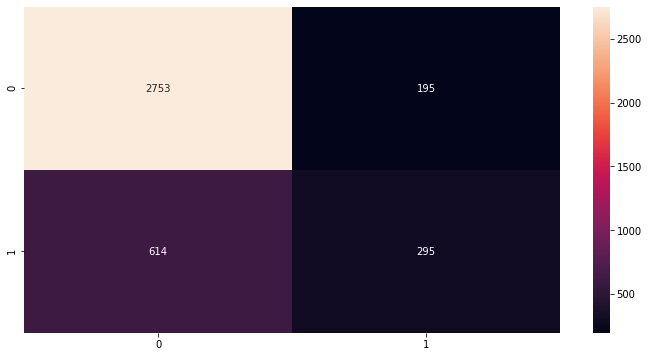

In [53]:
get_metrics(y_FNN_test, X_FNN_test_pad, F_model)

### Saving the model

In [54]:
# Colab
# model_name = 'F_model'

# Notebook
model_name = '../raw_data/F_model'

F_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/F_model/assets


### Uploading the model

In [55]:
reconstructed_F_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 79.03%
recall: 32.45%
precision: 60.20%
f1: 42.17%
--------------------------------------------------------------------------------


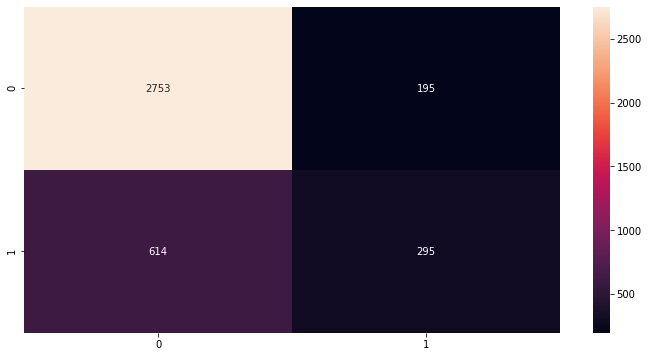

In [56]:
get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_F_model)

### `F_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 46.97%
recall: 10.21%
precision: 47.81%
f1: 16.82%
--------------------------------------------------------------------------------


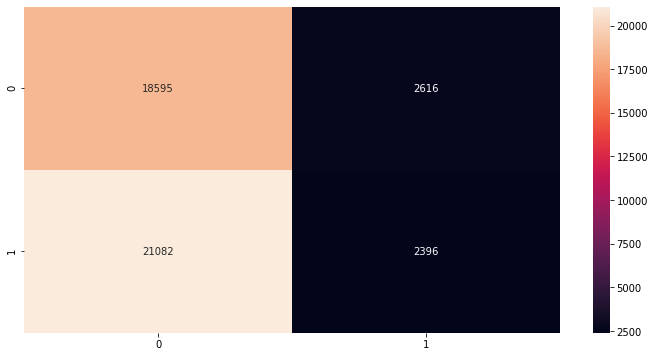

In [58]:
X_BIS_pad = prep_text(X_BIS, tokenizer_F, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_F_model)

### `F_model` evaluation on  `politifact_scrap`

--------------------------------------------------------------------------------
acc: 47.95%
recall: 13.09%
precision: 58.97%
f1: 21.43%
--------------------------------------------------------------------------------


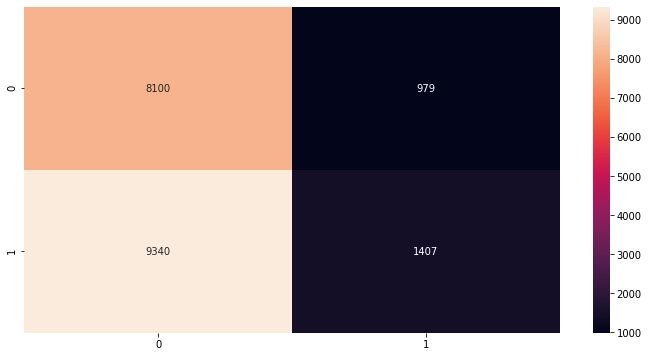

In [59]:
X_P_pad = prep_text(X_P, tokenizer_F, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_F_model)

## `Bisaillon`

### Model

In [60]:
embedding_matrix_B = get_embedding(archive, tokenizer_B, **hparams)

print('-'*80)
print(f"embedding_matrix_B shape: {embedding_matrix_B.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_B shape: (12714, 100)
--------------------------------------------------------------------------------


In [62]:
init_model(embedding_matrix_B, **hparams).summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 40, 100)           1271400   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 1, 128)          

### Training

In [63]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

B_model = init_model(embedding_matrix_B, **hparams)

history = B_model.fit(X_BIS_train_pad, 
                  y_BIS_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
224/224 [==============================] - 6s 25ms/step - loss: 0.2538 - accuracy: 0.8809 - precision: 0.8896 - recall: 0.8703 - val_loss: 0.2136 - val_accuracy: 0.9150 - val_precision: 0.9107 - val_recall: 0.9278
Epoch 2/30
224/224 [==============================] - 5s 23ms/step - loss: 0.1615 - accuracy: 0.9391 - precision: 0.9507 - recall: 0.9329 - val_loss: 0.1921 - val_accuracy: 0.9202 - val_precision: 0.9305 - val_recall: 0.9152
Epoch 3/30
224/224 [==============================] - 5s 24ms/step - loss: 0.1169 - accuracy: 0.9563 - precision: 0.9654 - recall: 0.9513 - val_loss: 0.2222 - val_accuracy: 0.9218 - val_precision: 0.9495 - val_recall: 0.8978
Epoch 4/30
224/224 [==============================] - 5s 24ms/step - loss: 0.0863 - accuracy: 0.9686 - precision: 0.9751 - recall: 0.9652 - val_loss: 0.1992 - val_accuracy: 0.9225 - val_precision: 0.9255 - val_recall: 0.9260
Epoch 5/30
224/224 [==============================] - 6s 25ms/step - loss: 0.0592 - accuracy: 0.9773

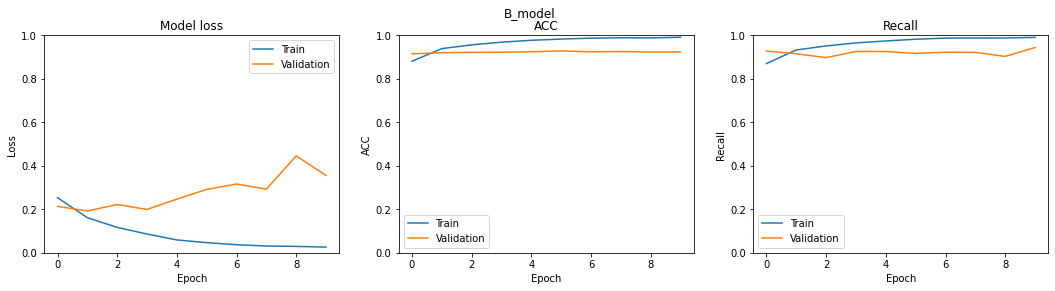

In [64]:
plot_loss(history, title='B_model')

--------------------------------------------------------------------------------
acc: 92.82%
recall: 92.53%
precision: 93.58%
f1: 93.05%
--------------------------------------------------------------------------------


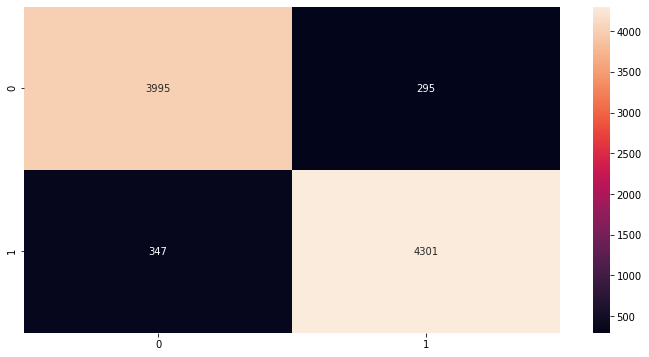

In [65]:
get_metrics(y_BIS_test, X_BIS_test_pad, B_model)

### Saving the model

In [66]:
# Colab
# model_name = 'B_model'

# Notebook
model_name = '../raw_data/B_model'

B_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/B_model/assets


### Uploading the model

In [67]:
reconstructed_B_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 92.82%
recall: 92.53%
precision: 93.58%
f1: 93.05%
--------------------------------------------------------------------------------


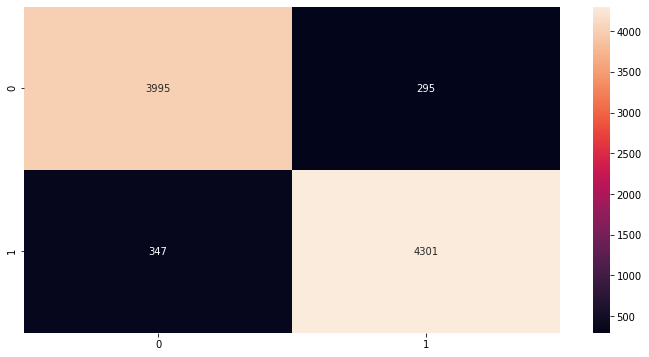

In [68]:
get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_B_model)

### `B_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 38.03%
recall: 79.83%
precision: 25.63%
f1: 38.80%
--------------------------------------------------------------------------------


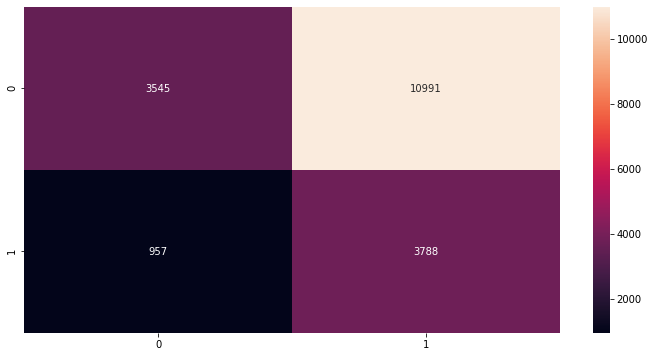

In [69]:
X_FNN_pad = prep_text(X_FNN, tokenizer_B, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_B_model)

### `B_model` evaluation on `politifact scrap`

--------------------------------------------------------------------------------
acc: 52.70%
recall: 76.72%
precision: 54.53%
f1: 63.75%
--------------------------------------------------------------------------------


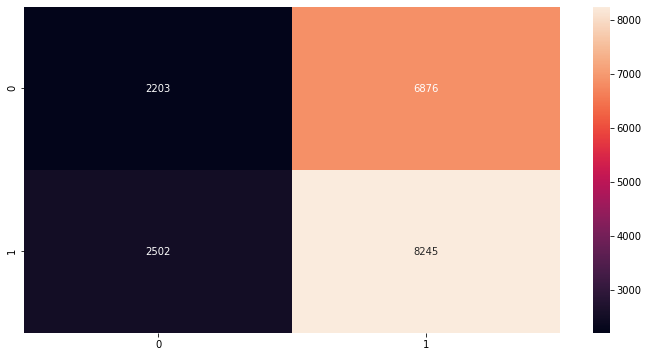

In [70]:
X_P_pad = prep_text(X_P, tokenizer_B, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_B_model)

## `All`

### Model

In [71]:
embedding_matrix_ALL = get_embedding(archive, tokenizer_ALL, **hparams)

print('-'*80)
print(f"embedding_matrix_ALL shape: {embedding_matrix_ALL.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix_ALL shape: (25527, 100)
--------------------------------------------------------------------------------


In [73]:
init_model(embedding_matrix_ALL, **hparams).summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 100)           2552700   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 8, 128)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 1, 128)          

### Training

In [74]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

ALL_model = init_model(embedding_matrix_ALL, **hparams)

history = ALL_model.fit(X_ALL_train_pad, 
                  y_ALL_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
419/419 [==============================] - 10s 21ms/step - loss: 0.4532 - accuracy: 0.7913 - precision: 0.8048 - recall: 0.7350 - val_loss: 0.4375 - val_accuracy: 0.7895 - val_precision: 0.7547 - val_recall: 0.8135
Epoch 2/30
419/419 [==============================] - 9s 22ms/step - loss: 0.3682 - accuracy: 0.8231 - precision: 0.8362 - recall: 0.7694 - val_loss: 0.4061 - val_accuracy: 0.8022 - val_precision: 0.8061 - val_recall: 0.7587
Epoch 3/30
419/419 [==============================] - 10s 25ms/step - loss: 0.3234 - accuracy: 0.8464 - precision: 0.8539 - recall: 0.8069 - val_loss: 0.4032 - val_accuracy: 0.8056 - val_precision: 0.8030 - val_recall: 0.7731
Epoch 4/30
419/419 [==============================] - 9s 22ms/step - loss: 0.2835 - accuracy: 0.8671 - precision: 0.8790 - recall: 0.8273 - val_loss: 0.4298 - val_accuracy: 0.8063 - val_precision: 0.8339 - val_recall: 0.7306
Epoch 5/30
419/419 [==============================] - 9s 22ms/step - loss: 0.2511 - accuracy: 0.88

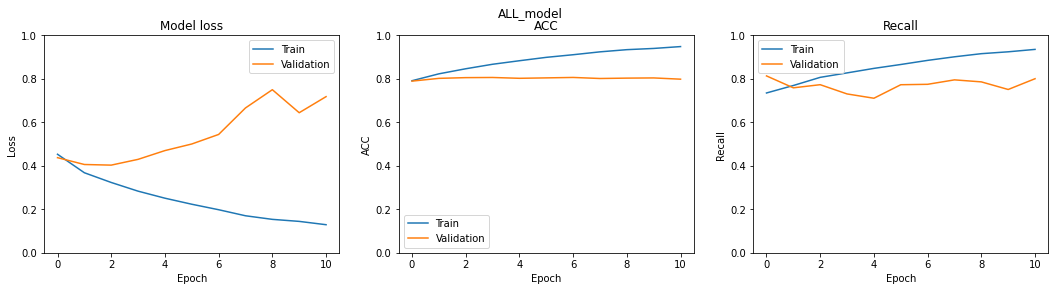

In [77]:
plot_loss(history, title='ALL_model')

--------------------------------------------------------------------------------
acc: 81.71%
recall: 78.53%
precision: 81.62%
f1: 80.04%
--------------------------------------------------------------------------------


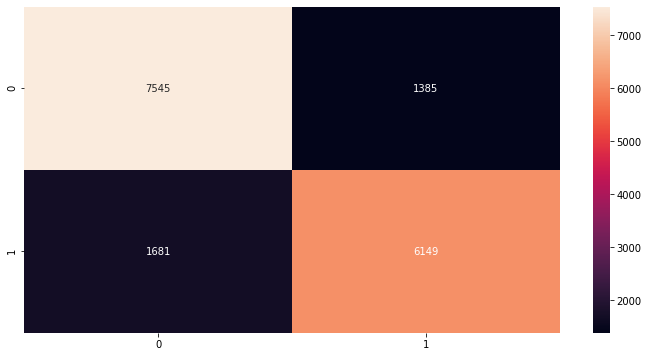

In [78]:
get_metrics(y_ALL_test, X_ALL_test_pad, ALL_model)

### Saving the model

In [79]:
# Colab
# model_name = 'ALL_model'

# Notebook
model_name = '../raw_data/ALL_model'

ALL_model.save(model_name)

INFO:tensorflow:Assets written to: ../raw_data/ALL_model/assets


### Uploading the model

In [112]:
reconstructed_ALL_model = tf.keras.models.load_model(model_name)

--------------------------------------------------------------------------------
acc: 81.71%
recall: 78.53%
precision: 81.62%
f1: 80.04%
--------------------------------------------------------------------------------


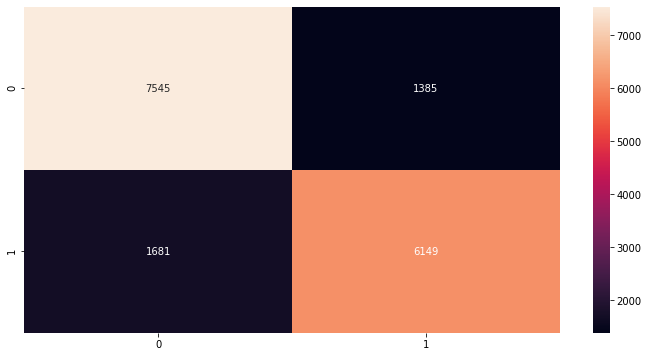

In [113]:
get_metrics(y_ALL_test, X_ALL_test_pad, reconstructed_ALL_model)

### `ALL_model` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
acc: 67.50%
recall: 64.40%
precision: 72.22%
f1: 68.09%
--------------------------------------------------------------------------------


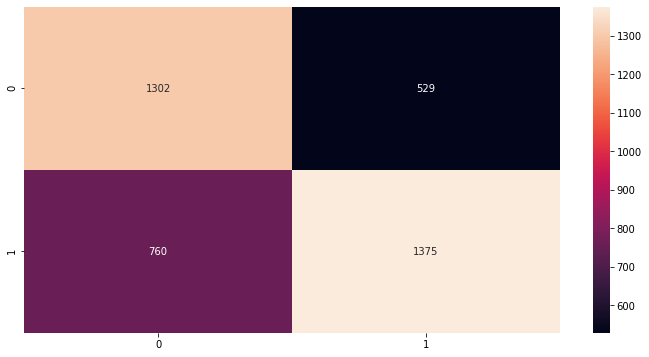

In [82]:
X_P_test_pad = prep_text(X_P_test, tokenizer_ALL, **hparams)

get_metrics(y_P_test, X_P_test_pad, reconstructed_ALL_model)

### `ALL_model` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 81.38%
recall: 70.63%
precision: 58.74%
f1: 64.14%
--------------------------------------------------------------------------------


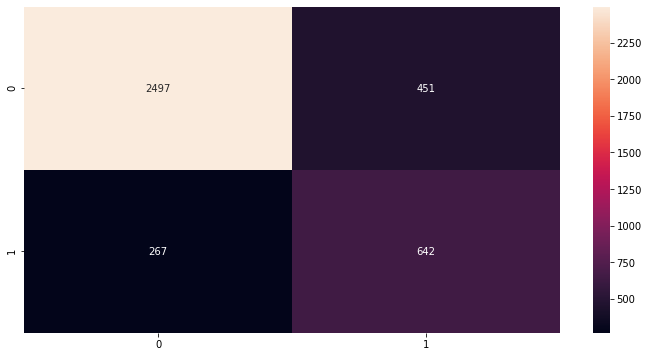

In [83]:
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_ALL, **hparams)

get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_ALL_model)

### `ALL_model` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 95.37%
recall: 94.00%
precision: 97.00%
f1: 95.48%
--------------------------------------------------------------------------------


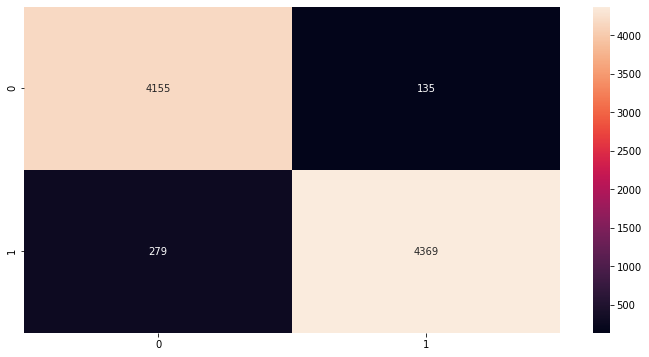

In [84]:
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_ALL, **hparams)

get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_ALL_model)

## Summary

In [126]:
X_pad = prep_text(X_P, tokenizer_P, **hparams)
X_pad.shape

y_probs = reconstructed_ALL_model.predict(X)

(19826, 40)

In [135]:
def get_summary(model_names, datas, tokenizers):

    X_data = [[X_P_test, X_FNN, X_BIS, X_all],
              [X_P, X_FNN_test, X_BIS, X_all],
              [X_P, X_FNN, X_BIS_test, X_all],
              [X_P_test, X_FNN_test, X_BIS_test, X_ALL_test]]

    y_data = [[y_P_test, y_FNN, y_BIS, y_all],
              [y_P, y_FNN_test, y_BIS, y_all],
              [y_P, y_FNN, y_BIS_test, y_all],
              [y_P_test, y_FNN_test, y_BIS_test, y_ALL_test]]

    model_list = []
    data_list = []
    tokenizer_list = []
    acc_list = []
    recall_list = []
    prec_list = []
    f1_list = []
    
    for model_name, tokenizer, Xs, ys in zip(model_names, tokenizers, X_data, y_data):

        for data, X, y in zip(datas, Xs, ys):

#             print('-'*80)
#             print(model_name)
#             print(data)
#             print(X.shape)
#             print(y.shape)

            X_pad = prep_text(X, tokenizer, **hparams)
            reconstructed_model = tf.keras.models.load_model(model_name)
            y_probs = reconstructed_model.predict(X_pad)
            y_preds = np.where(y_probs > 0.5, 1, 0)

            model_list.append(model_name)
            data_list.append(data)
            acc_list.append(np.round(accuracy_score(y, y_preds), 2))
            recall_list.append(np.round(recall_score(y, y_preds), 2))
            prec_list.append(np.round(precision_score(y, y_preds), 2))
            f1_list.append(np.round(f1_score(y, y_preds), 2))

    df = pd.DataFrame({'model': model_list, 
                   'data': data_list, 
                   'acc': acc_list,
                   'recall': recall_list, 
                   'prec': prec_list,
                   'f1': f1_list,
    })

    return df

In [136]:
model_names = ['../raw_data/P_model',
               '../raw_data/F_model', 
               '../raw_data/B_model', 
               '../raw_data/ALL_model']

datas = ['politifact', 'FakeNewsNET', 'Bisaillon', 'All']

tokenizers = [tokenizer_P, 
             tokenizer_F,
             tokenizer_B,
             tokenizer_ALL]

df = get_summary(model_names, datas, tokenizers)
df.head(20)

,model,data,acc,recall,prec,f1
0,../raw_data/P_model,politifact,0.64,0.60,0.70,0.64
1,../raw_data/P_model,FakeNewsNET,0.30,0.94,0.25,0.40
2,../raw_data/P_model,Bisaillon,0.54,0.92,0.54,0.68
3,../raw_data/P_model,All,0.52,0.84,0.49,0.62
4,../raw_data/F_model,politifact,0.48,0.13,0.59,0.21
5,../raw_data/F_model,FakeNewsNET,0.79,0.32,0.60,0.42
6,../raw_data/F_model,Bisaillon,0.47,0.10,0.48,0.17
7,../raw_data/F_model,All,0.55,0.14,0.57,0.23
8,../raw_data/B_model,politifact,0.53,0.77,0.55,0.64
9,../raw_data/B_model,FakeNewsNET,0.38,0.80,0.26,0.39


In [137]:
file_path = '../raw_data/DL_summary.csv'

df.to_csv(file_path, index=False)

## Prediction

In [98]:
# Colab
model_name = 'ALL_model'

# Notebook
model_name = '../raw_data/ALL_model'

reconstructed_ALL_model = tf.keras.models.load_model(model_name)

In [99]:
fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [102]:
sample = [fake0, fake1, fake2, true0, true1, true2]

# Preprocessing
X_sample_clean = [clean(text) for text in sample] 
X_sample_pad = prep_text(X_sample_clean, tokenizer_ALL, **hparams)

# Prediction
y_preds = reconstructed_ALL_model.predict(X_sample_pad)

print('-'*80)
print(y_preds)
print('-'*80)

--------------------------------------------------------------------------------
[[0.85778475]
 [0.77794206]
 [0.4333899 ]
 [0.83911407]
 [0.47911212]
 [0.31759608]]
--------------------------------------------------------------------------------
